<a href="https://colab.research.google.com/github/GubioGL/Feixes-pacialmente-coerentes/blob/main/Codigo_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install LightPipes

In [1]:
# Importando as bibliotecas
from LightPipes import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt

In [2]:
# Definindo os campo e constante da Eq.32
def Lambda(M,N,sigma,delta):
  a = 1/(4*sigma**2) #
  b = 1/(2*delta**2) #
  c = 2*np.sqrt( a**2 + 2*a*b )
  L = ( np.pi/(a + b + c/2) )*( (a + b - c/2)/( a + b + c/2 ) )**( abs(M)/2 + N )
  return L

def Laguerre_G(n,m,sigma,delta):
    a = 1/(4*sigma**2) # [L]^-2
    b = 1/(2*delta**2) # [L]^-2
    c = 2*np.sqrt( a**2 + 2*a*b )
    w = np.sqrt( 2/c )

    x = np.arange(-N/2, N/2,1)*dx
    xx,yy = np.meshgrid(x,x)

    r    = np.sqrt(xx**2+yy**2)
    C    = np.sqrt(2*math.factorial(jj)/(np.pi*math.factorial(n+abs(m))))
    PL   = sp.special.assoc_laguerre(2*r**2/w**2,n,abs(m))
    Fase = np.exp(- 1j*m*np.arctan2(yy,xx) )

    LG   = C*1/w*(r*np.sqrt(2)/w)**abs(m)*PL*np.exp(-r**2/w**2)*Fase
    return LG

In [13]:
#Parâmetros do feixe GSM
sigma = .2*mm        # largura do feixe
delta = .1*mm        # comprimento de coerência
L = 100
P = 30

lambd = 620*nm        # light wavelength
N     = 2**7          # Dimensão
dx    = 10*um         # Tamanho do pixel

# Gerando os campos para a soma incoerente
Numero_de_Soma_Inc = 0
for j in range(-L,L+1):
    for jj in range(P+1):
        cutoff  = Lambda(j,jj,sigma,delta)/Lambda(0,0,sigma,delta)
        if (cutoff >= 0.015):
            Numero_de_Soma_Inc +=1

Gerando so campos

In [14]:
Campo =  np.exp( 1j*np.zeros((N,N,Numero_de_Soma_Inc))) # Campo

i = 0
for j in range(-L,L+1):
    for jj in range(P+1):
        cutoff  = Lambda(j,jj,sigma,delta)/Lambda(0,0,sigma,delta)
        if (cutoff >= 0.015):
            Campo[:,:,i] = np.sqrt(Lambda(j,jj,sigma,delta))*Laguerre_G(n=jj,m=j,sigma=sigma,delta=delta)
            i += 1

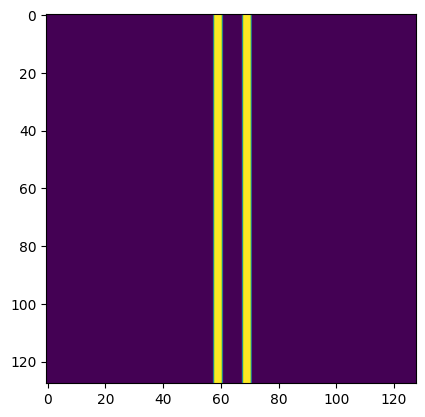

In [15]:
# Criando a fenda dupla
x  = np.arange(-N/2,N/2,1)*dx;
[xx,yy] = np.meshgrid(x,x);

d0 = .1*mm;
a0 = .03*mm;
# make slit
fslit = (np.ones_like(xx)*(abs(xx+(d0/2))<=a0/2) +
         np.ones_like(xx)*(abs(xx-(d0/2))<=a0/2));
plt.imshow(fslit);plt.show()

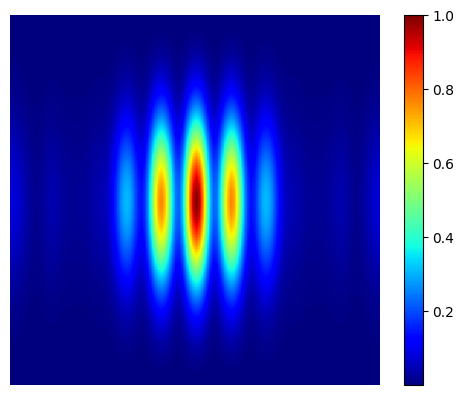

In [21]:
F  = Begin(abs(x[0])*2,lambd,N)
# passando pelas fendas --> soma incoerente
imagem =[0]
FF = F.copy(F)

for ii in range(Numero_de_Soma_Inc):
  FF.field = Campo[:,:,ii]*fslit
  FF1      = Forvard(2.0*cm,FF)
  imagem     += Intensity(FF1)

imagem = imagem/imagem.max()
plt.imshow(imagem,cmap = "jet");
plt.axis('off')
plt.colorbar()

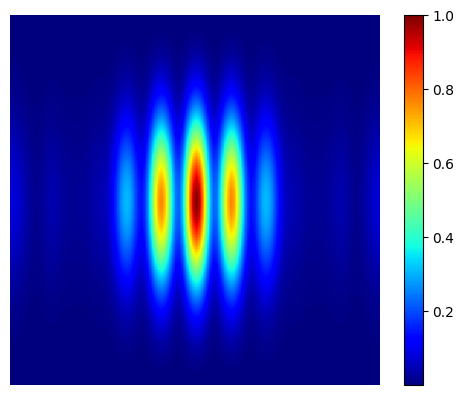

In [22]:
plt.imshow(imagem,cmap = "jet");
plt.axis('off')
plt.colorbar()
plt.savefig("inferefencia_DMC.png", bbox_inches='tight',dpi=500)

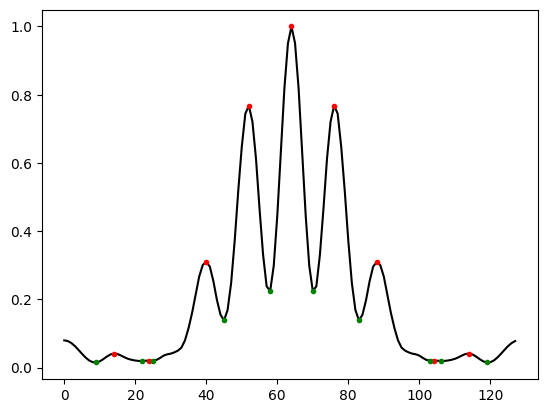

In [23]:
from scipy.signal import argrelextrema
# Pegando apenas o centro da imagem
frajas= imagem[N//2,:]
# Determinado todos os máximo e mínimos
maximos = argrelextrema(frajas, np.greater)
minimos = argrelextrema(frajas, np.less)

plt.plot(frajas,"k")
plt.plot(maximos[0], frajas[maximos],"r.")
plt.plot(minimos[0], frajas[minimos],"g.")

plt.show()

Vamos determinar o máximo absoluto

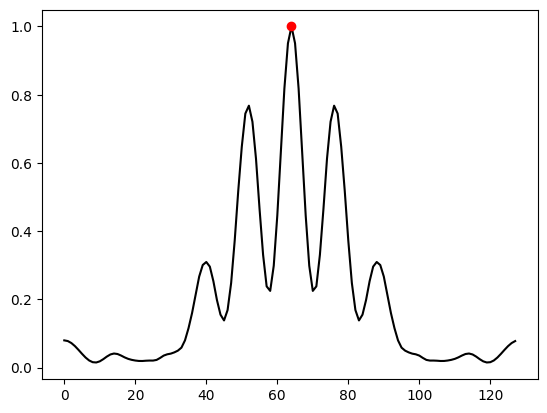

In [24]:
maximo_valor = frajas[maximos].max()
maximo_index = np.where( frajas == frajas[maximos].max())

plt.plot(frajas,"k")
plt.plot(maximo_index, maximo_valor,"ro")
plt.show()

Iremos agora definir uma função para encontrar o indice do primeiro minimo a parti do indice do valor maximo

In [25]:
def primeiro_maior(lista, valor):
    for i in lista:
        if i > valor:
            return i
    return None

In [26]:
# sabemos que a lista de minimo é
print(minimos[0], "- indice do valor maximo:",maximo_index[0][0] )

[  9  22  25  45  58  70  83 103 106 119] - indice do valor maximo: 64


podemos ver que o primeiro mínimo apos o máximo

In [28]:
minimo_index = primeiro_maior(minimos[0],maximo_index[0][0])
print(" Indice do primeiro minimo:",minimo_index,"\n Valor primeiro minimo:",frajas[minimo_index])

 Indice do primeiro minimo: 70 
 Valor primeiro minimo: 0.22490731429545258


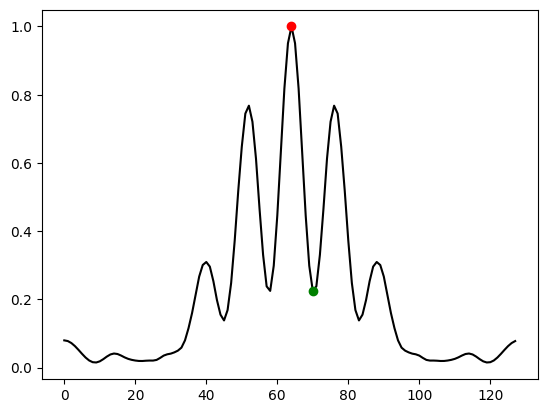

In [29]:
minimo_valor = frajas[minimo_index]

plt.plot(frajas,"k")
plt.plot(maximo_index, maximo_valor,"ro")
plt.plot(minimo_index, minimo_valor,"go")
plt.show()

Agora temos todos os valores para determinar a visibilidade.



In [30]:
V = ( maximo_valor - minimo_valor)/( maximo_valor + minimo_valor)
V

0.6327766000404436

Essa visibilidade é apenas para a regiao com y = N/2.

É interessante fazer a media de alguns pontos da regiao central

In [31]:
VisibilidadeN =0
V_plot = []
count = 0
for i in  range(N//2 - 50,N//2 + 50):
    # Pegando apenas o centro da imagem
    frajas= imagem[i,:]
    # Determinado todos os máximo e mínimos
    maximos = argrelextrema(frajas, np.greater)
    minimos = argrelextrema(frajas, np.less)
    # valor do máximo
    maximo_valor = frajas[maximos].max()
    # indice do máximo
    maximo_index = np.where( frajas == frajas[maximos].max())
    # indice de 1° minimo
    minimo_index = primeiro_maior(minimos[0],maximo_index[0][0])
    # valor de 1° minimo
    minimo_valor = frajas[minimo_index]
    V = ( maximo_valor - minimo_valor)/( maximo_valor + minimo_valor)
    VisibilidadeN += V
    V_plot.append(V)
    count+=1

print("Valor medio da grau de coerencia/Visibilidade ",VisibilidadeN/count)

Valor medio da grau de coerencia/Visibilidade  0.654193857391908


Figura da variação da visibilidade determinada

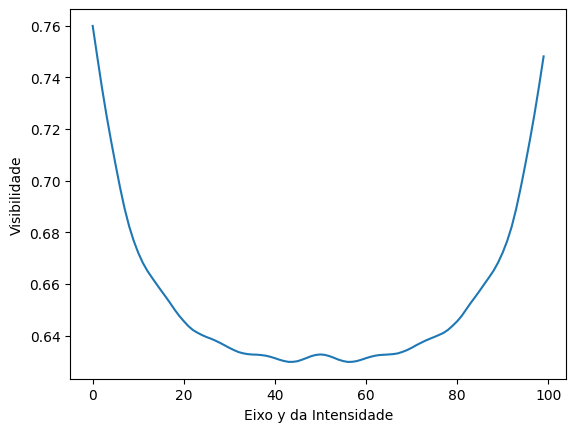

In [32]:
plt.plot(V_plot)
plt.xlabel('Eixo y da Intensidade')
plt.ylabel("Visibilidade")
plt.show()